# Topic Modelling

In [51]:
import string

import numpy as np
import scipy
import pandas as pd
import re

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer

import html

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

## Load Data

In [52]:
data = pd.read_json('venv/data/presidential_speeches.json') # load data
data.sort_values(by=['date'], inplace=True) # sort by data
data.reset_index(drop=True, inplace=True) # reset index

## Add relevant metadata

In [53]:
# sort presidents to their parties
president_list = []
for i in range(len(data['president'].unique())):
    president_list.append(data['president'].unique()[i])
parties_list= ['Federalist', 'Democratic-Republican', 'National Republican', 'Democratic', 'Whig', 'Republican', 'Democratic (Union)']
sort_party = [0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 3, 4, 4, 5, 3, 3, 6, 5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 5, 5, 3, 5, 3, 5, 3, 5, 3]
party = []
for i in range(len(sort_party)):
    party.append(parties_list[sort_party[i]])
data['party'] = pd.Series(dtype='string')
for i in range(len(president_list)):
    data['party'][data['president'] == president_list[i]] = party[i]
# assign each speech its respective era
data['era'] = pd.Series(dtype='string')
era_list = ['Early Republic', 'Jacksonian Democracy', 'Sectional Conflict', 'Gilded Age', 'Progressive Era', 'Depression and World Conflict', 'Social Change and Soviet Relations', 'Globalization']
for i in range(len(data)):
    if data['date'][i] < pd.Timestamp('1829-01-01T12'):
        data['era'][i] =  era_list[0]
    if pd.Timestamp('1829-01-01T12') <= data['date'][i] < pd.Timestamp('1853-01-01T12'):
        data['era'][i] = era_list[1]
    elif pd.Timestamp('1853-01-01T12') <= data['date'][i] < pd.Timestamp('1881-01-01T12'):
        data['era'][i] = era_list[2]
    elif pd.Timestamp('1881-01-01T12') <= data['date'][i] < pd.Timestamp('1897-01-01T12'):
        data['era'][i] = era_list[3]
    elif pd.Timestamp('1897-01-01T12') <= data['date'][i] < pd.Timestamp('1921-01-01T12'):
        data['era'][i] = era_list[4]
    elif pd.Timestamp('1921-01-01T12') <= data['date'][i] < pd.Timestamp('1961-01-01T12'):
        data['era'][i] = era_list[5]
    elif pd.Timestamp('1961-01-01T12') <= data['date'][i] < pd.Timestamp('1989-01-01T12'):
        data['era'][i] = era_list[6]
    elif pd.Timestamp('1989-01-01T12') <= data['date'][i]:
        data['era'][i] = era_list[7]

In [54]:
data['transcript'].replace(to_replace='(Applause.)', regex=True, value='', inplace=True)
data['transcript'].replace(to_replace='(Laughter.)', regex=True, value='', inplace=True)

In [55]:
for i in range(len(data)):
    data['transcript'][i] = data['transcript'][i].replace('\'', '')

C:\Users\Enno\AppData\Local\Temp/ipykernel_21136/1438919703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['transcript'][i] = data['transcript'][i].replace('\'', '')


## Preprocessing

The Following section is code adapted from Srikanth Shenoy and can be found under https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8 (accessed on 02/10/2023)

In [68]:
import string
import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from textblob import TextBlob
from unidecode import unidecode
import matplotlib.pyplot as plt 

In [57]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [58]:
def lemmatize_pos_tagged_text(text, lemmatizer, pos_tag_dict):
  sentences = nltk.sent_tokenize(text)
  new_sentences = []

  for sentence in sentences:
    sentence = sentence.lower()
    new_sentence_words = []
    #one pos_tuple for sentence
    pos_tuples = nltk.pos_tag(nltk.word_tokenize(sentence)) 

    for word_idx, word in enumerate(nltk.word_tokenize(sentence)):
      nltk_word_pos = pos_tuples[word_idx][1]
      wordnet_word_pos = pos_tag_dict.get(
                          nltk_word_pos[0].upper(), None)
      if wordnet_word_pos is not None:
        new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
      else:
        new_word = lemmatizer.lemmatize(word)

      new_sentence_words.append(new_word)

    new_sentence = " ".join(new_sentence_words)
    new_sentences.append(new_sentence)

  return " ".join(new_sentences)

In [59]:

class NltkPreprocessingSteps:
  def __init__(self, X):
    self.X = X

    self.sw_nltk = stopwords.words('english')
    # remove some noise
    new_stopwords = ['<*>', 'q', 'yeah', 'guy', 'okay', 'ahead', 'mr', 'st', 'really', 'please', 'yes', 'sir', 'youn', 'u', 'get']
    self.sw_nltk.extend(new_stopwords)
    self.sw_nltk.remove('not')

    self.pos_tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

    # '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~' 32 punctuations in python
    # we dont want to replace . first time around
    self.remove_punctuations = string.punctuation.replace('.','')

  def remove_html_tags(self):
    self.X = self.X.apply(
            lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return self

  def replace_diacritics(self):
    self.X = self.X.apply(
            lambda x: unidecode(x, errors="preserve"))
    return self

  def to_lower(self):
    self.X = np.apply_along_axis(lambda x: x.lower(), self.X)
    return self

  def expand_contractions(self):
    self.X = self.X.apply(
            lambda x: " ".join([contractions.fix(expanded_word) 
                        for expanded_word in x.split()]))
    return self

  def remove_numbers(self):
    self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
    return self

  def replace_dots_with_spaces(self):
    self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
    return self

  def remove_punctuations_except_periods(self):
    self.X = self.X.apply(
                 lambda x: re.sub('[%s]' %
                  re.escape(self.remove_punctuations), '' , x))
    return self

  def remove_all_punctuations(self):
    self.X = self.X.apply(lambda x: re.sub('[%s]' %
                          re.escape(string.punctuation), '' , x))
    return self

  def remove_double_spaces(self):
    self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
    return self

  def fix_typos(self):
    self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
    return self

  def remove_stopwords(self):
    # remove stop words from token list in each column
    self.X = self.X.apply(
            lambda x: " ".join([ word for word in x.split() 
                     if word not in self.sw_nltk]) )
    return self

  def lemmatize(self):
    lemmatizer = WordNetLemmatizer()
    self.X = self.X.apply(lambda x: lemmatize_pos_tagged_text(
                           x, lemmatizer, self.pos_tag_dict))
    return self

  def get_processed_text(self):
    return self.X

In [60]:
# apply preprocessing
txt_preproc = NltkPreprocessingSteps(data['transcript'])
processed_text = \
    txt_preproc \
    .remove_html_tags()\
    .replace_diacritics()\
    .expand_contractions()\
    .remove_numbers()\
    .remove_punctuations_except_periods()\
    .lemmatize()\
    .remove_double_spaces()\
    .remove_all_punctuations()\
    .remove_stopwords()\
    .get_processed_text()

## Topic Modelling

In [61]:
for i in range(len(processed_text)):
    processed_text[i] = list(processed_text[i].split(' '))

In [62]:
# get bigrams
from gensim.models import Phrases
bigram = Phrases(processed_text, min_count=20)
for i in range(len(processed_text)):
    for token in bigram[processed_text[i]]:
        if '_' in token:
            processed_text[i].append(token)

In [63]:
dictionary_list = []
bow_corpus_list = []
for i in range(len(era_list)):
    dictionary_list.append(Dictionary(processed_text[data[data['era'] == era_list[i]].index]))
    dictionary_list[i].filter_extremes(no_below=20, no_above=0.5)
    bow_corpus_list.append([dictionary_list[i].doc2bow(text) for text in processed_text[data[data['era'] == era_list[i]].index]])

In [64]:
from gensim.models.coherencemodel import CoherenceModel

In [65]:
# LDA
chunksize = 100
passes = 30
iterations = 200
eval_every = None
num_topics = 5
model_list = []
coherence_list = []
for i in range(len(era_list)):
    model = gensim.models.LdaModel(
    corpus=bow_corpus_list[i],
    id2word=dictionary_list[i],
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )
    topics = model.show_topics(
    num_topics=num_topics,
    num_words=10,
    log=False,
    formatted=False)
    cm = CoherenceModel(model=model, corpus=bow_corpus_list[i], coherence='u_mass')
    coherence = cm.get_coherence()
    coherence_list.append(coherence)
    model_list.append(topics)

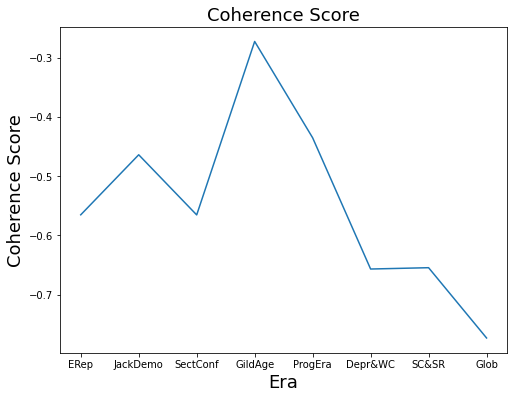

In [76]:
# print coherences
plt.figure(figsize=(8, 6))
plt.plot(['ERep', 'JackDemo', 'SectConf', 'GildAge', 'ProgEra', 'Depr&WC', 'SC&SR', 'Glob'], coherence_list)
plt.xlabel('Era', fontsize=18)
plt.ylabel("Coherence Score", fontsize=18)
plt.title('Coherence Score', fontsize=18)
plt.savefig('coherence_era.png', dpi = 100)

In [67]:
for i in range(len(era_list)-1):
    print(era_list[i], ':')
    for topic_id, topic in model_list[i]:
        print([word for word, _ in topic])

Early Republic :
['men', 'see', 'happiness', 'opinion', 'liberty', 'wish', 'ought', 'let', 'man', 'desire']
['upon', 'treaty', 'improvement', 'say', 'party', 'condition', 'common', 'execution', 'president', 'secure']
['british', 'enemy', 'american', 'britain', 'great_britain', 'command', 'militia', 'success', 'arm', 'naval']
['spain', 'treaty', 'party', 'territory', 'high', 'article', 'revenue', 'exist', 'tribe', 'extent']
['vessel', 'session', 'treasury', 'amount', 'debt', 'minister', 'france', 'british', 'last_session', 'sum']
Jacksonian Democracy :
['resolution', 'legislature', 'south', 'proceeding', 'liberty', 'execute', 'institution', 'federal', 'member', 'court']
['island', 'british', 'men', 'vessel', 'life', 'never', 'man', 'liberty', 'north', 'political']
['indian', 'bank', 'institution', 'debt', 'trade', 'appropriation', 'payment', 'minister', 'intercourse', 'improvement']
['bank', 'bill', 'deposit', 'improvement', 'currency', 'institution', 'appropriation', 'federal', 'millio